In [14]:
# =========================================================
# CELL 1: INSTALL REQUIRED LIBRARIES (Run Once)
# Installs CatBoost, TensorFlow, and SMOTE dependencies
# =========================================================

!pip install -q catboost tensorflow imbalanced-learn


In [15]:
# =========================================================
# CELL 2: SET RANDOM SEEDS FOR REPRODUCIBILITY
# Ensures consistent results across runs
# =========================================================

import os, random
import numpy as np
import tensorflow as tf

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [16]:
# =========================================================
# CELL 3: IMPORT LIBRARIES
# Includes data handling, preprocessing, models, and metrics
# =========================================================

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve,
    precision_recall_curve
)

from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [17]:
# =========================================================
# CELL 4: LOAD UNSW-NB15 DATASET
# Loads training and testing CSV files
# =========================================================

train_df = pd.read_csv("UNSW_NB15_training-set.csv")
test_df  = pd.read_csv("UNSW_NB15_testing-set.csv")


In [18]:
# =========================================================
# CELL 5: DATASET PREVIEW AND EXPLORATORY CHECKS
# Displays structure, missing values, and class distribution
# =========================================================

# ===============================
# DISPLAY SETTINGS (NO CUTTING)
# ===============================
pd.set_option('display.max_columns', None)      # Show all columns
pd.set_option('display.max_colwidth', None)     # Show full column content
pd.set_option('display.width', 1000)            # Increase display width
pd.set_option('display.expand_frame_repr', False)  # Prevent column wrapping


# ===============================
# TRAIN DATA PREVIEW
# ===============================
print("===== TRAIN DATA PREVIEW =====")
display(train_df.head(5))   # All columns will be visible

print("\nShape:", train_df.shape)

print("\nColumns:")
display(train_df.columns)

print("\nData Types:")
display(train_df.dtypes)

print("\nMissing Values:")
display(train_df.isnull().sum())

print("\nStatistical Summary:")
display(train_df.describe())

print("\nTarget Distribution (Train):")
display(train_df['label'].value_counts())


# ===============================
# TEST DATA PREVIEW
# ===============================
print("\n===== TEST DATA PREVIEW =====")
display(test_df.head(5))   # All columns visible

print("\nShape:", test_df.shape)

print("\nColumns:")
display(test_df.columns)

print("\nData Types:")
display(test_df.dtypes)

print("\nMissing Values:")
display(test_df.isnull().sum())

print("\nStatistical Summary:")
display(test_df.describe())

print("\nTarget Distribution (Test):")
display(test_df['label'].value_counts())









===== TRAIN DATA PREVIEW =====


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0



Shape: (175341, 45)

Columns:


Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'], dtype='object')


Data Types:


,0
id,int64
dur,float64
proto,object
service,object
state,object
spkts,int64
dpkts,int64
sbytes,int64
dbytes,int64
rate,float64



Missing Values:


,0
id,0
dur,0
proto,0
service,0
state,0
spkts,0
dpkts,0
sbytes,0
dbytes,0
rate,0



Statistical Summary:


,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,87671.000000,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,6.712056e+05,4.953000,6.948010,985.976864,88.216296,4.976254e+03,604.353826,116.257339,9.692504e+08,9.688770e+08,115.013625,0.041396,0.021020,0.020375,136.751769,124.173382,0.105982,2.144292e+03,9.306437,1.304179,6.193936,5.383538,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,0.680622
std,50616.731112,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,2.421312e+06,66.005059,52.732999,7242.245841,987.093195,4.496585e+04,4061.043281,127.001024,1.355264e+09,1.354000e+09,126.886530,0.079354,0.043400,0.040506,204.677360,258.317056,0.776911,5.420797e+04,10.704331,0.954406,8.052476,8.047104,5.783585,10.956186,0.126048,0.126048,0.701208,8.321493,10.756952,0.124516,0.466237
min,1.000000,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,43836.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,87671.000000,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,1.447023e+03,0.000000,0.000000,0.279733,0.006000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,131506.000000,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,2.784487e+04,3.000000,2.000000,55.156896,51.053000,2.513295e+03,114.990625,255.000000,1.916651e+09,1.913675e+09,255.000000,0.065481,0.023268,0.038906,100.000000,89.000000,0.000000,0.000000e+00,12.000000,2.000000,7.000000,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000,1.000000
max,175341.000000,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,2.242273e+07,4803.000000,5484.000000,84371.496000,56716.824000,1.460480e+06,289388.269700,255.000000,4.294959e+09,4.294882e+09,255.000000,2.518893,2.100352,1.520884,1504.000000,1458.000000,172.000000,6.558056e+06,63.000000,6.000000,51.000000,51.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000



Target Distribution (Train):


,count
label,
1,119341
0,56000



===== TEST DATA PREVIEW =====


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0



Shape: (82332, 45)

Columns:


Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'], dtype='object')


Data Types:


,0
id,int64
dur,float64
proto,object
service,object
state,object
spkts,int64
dpkts,int64
sbytes,int64
dbytes,int64
rate,float64



Missing Values:


,0
id,0
dur,0
proto,0
service,0
state,0
spkts,0
dpkts,0
sbytes,0
dbytes,0
rate,0



Statistical Summary:


,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.00000,8.233200e+04,8.233200e+04,82332.00000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,6.305470e+05,4.753692,6.308556,755.394301,121.701284,6.363075e+03,535.180430,133.45908,1.084642e+09,1.073465e+09,128.28662,0.055925,0.029256,0.026669,139.528604,116.275069,0.094277,1.595372e+03,9.546604,1.369273,5.744923,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,2.393001e+06,64.649620,55.708021,6182.615732,1292.378499,5.672402e+04,3635.305383,127.35700,1.390860e+09,1.381996e+09,127.49137,0.116022,0.070854,0.055094,208.472063,244.600271,0.542922,3.806697e+04,11.090289,1.067188,8.418112,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,2.112951e+03,1.000000,0.000000,0.557929,0.010000,1.762392e+01,0.000000,255.00000,2.788886e+07,2.856975e+07,255.00000,0.000551,0.000441,0.000080,65.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,1.585808e+04,3.000000,2.000000,63.409444,63.136369,3.219332e+03,128.459914,255.00000,2.171310e+09,2.144205e+09,255.00000,0.105541,0.052596,0.048816,100.000000,87.000000,0.000000,0.000000e+00,11.000000,2.000000,6.000000,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,2.082111e+07,5319.000000,5507.000000,60009.992000,57739.240000,1.483831e+06,463199.240100,255.00000,4.294950e+09,4.294881e+09,255.00000,3.821465,3.226788,2.928778,1504.000000,1500.000000,131.000000,5.242880e+06,63.000000,6.000000,59.000000,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000



Target Distribution (Test):


,count
label,
1,45332
0,37000


In [19]:
# =========================================================
# CELL 6: DATA CLEANING
# Handles missing values and removes unnecessary columns
# =========================================================

train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

train_df['service'] = train_df['service'].replace('-', 'unknown')
test_df['service']  = test_df['service'].replace('-', 'unknown')

train_df['label'] = train_df['label'].map({0: 'Normal', 1: 'Attack'})
test_df['label']  = test_df['label'].map({0: 'Normal', 1: 'Attack'})

train_df.drop(columns=['id', 'attack_cat'], inplace=True)
test_df.drop(columns=['id', 'attack_cat'], inplace=True)


In [20]:
# =========================================================
# CELL 7: ENCODE CATEGORICAL FEATURES
# Applies Label Encoding to categorical columns
# =========================================================

cat_cols = ['proto', 'service', 'state']

for col in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_df[col], test_df[col]]).astype(str))
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col]  = le.transform(test_df[col].astype(str))

target_le = LabelEncoder()
train_df['label'] = target_le.fit_transform(train_df['label'])
test_df['label']  = target_le.transform(test_df['label'])

X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_test  = test_df.drop('label', axis=1).values
y_test  = test_df['label'].values


In [21]:
# =========================================================
# CELL 8: FEATURE SCALING
# Standardizes numerical features
# =========================================================

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [22]:
# =========================================================
# CELL 9: FEATURE SELECTION (EQUILIBRIUM OPTIMIZER)
# Selects optimal subset of features
# =========================================================

def fitness(sol, X, y):
    if sol.sum() == 0:
        return 1
    Xs = X[:, sol == 1]
    skf = StratifiedKFold(3, shuffle=True, random_state=SEED)
    scores = []
    for tr, val in skf.split(Xs, y):
        clf = ExtraTreesClassifier(n_estimators=50, random_state=SEED, n_jobs=-1)
        clf.fit(Xs[tr], y[tr])
        scores.append(balanced_accuracy_score(y[val], clf.predict(Xs[val])))
    return 1 - np.mean(scores)

def EO(X, y, pop=10, iters=10):
    n_feat = X.shape[1]
    P = np.random.randint(0, 2, (pop, n_feat))
    F = np.array([fitness(p, X, y) for p in P])
    for _ in range(iters):
        elite = P[np.argsort(F)[:3]]
        eq = elite.mean(axis=0)
        for i in range(pop):
            P[i] = (np.random.rand(n_feat) < eq).astype(int)
            F[i] = fitness(P[i], X, y)
    return P[np.argmin(F)]

best_features = EO(X_train, y_train)

X_train = X_train[:, best_features == 1]
X_test  = X_test[:, best_features == 1]

print("Selected features:", X_train.shape[1])


Selected features: 25


In [24]:
# =========================================================
# CELL 10: STACKED AUTOENCODER (FEATURE REPRESENTATION)
# Learns compressed latent representation
# =========================================================

inp = Input(shape=(X_train.shape[1],))
x = Dense(64, activation='relu')(inp)
x = Dense(32, activation='relu')(x)
latent = Dense(16, activation='relu')(x)
x = Dense(32, activation='relu')(latent)
x = Dense(64, activation='relu')(x)
out = Dense(X_train.shape[1])(x)

autoencoder = Model(inp, out)
encoder = Model(inp, latent)

autoencoder.compile(optimizer=Adam(0.001), loss='mse')

autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=256,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True)],
    verbose=1
)

X_train_enc = encoder.predict(X_train)
X_test_enc  = encoder.predict(X_test)


Epoch 1/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4431 - val_loss: 0.0541
Epoch 2/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0728 - val_loss: 0.0383
Epoch 3/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0642 - val_loss: 0.0110
Epoch 4/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0233 - val_loss: 0.0091
Epoch 5/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0223 - val_loss: 0.0085
Epoch 6/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0200 - val_loss: 0.0072
Epoch 7/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0199 - val_loss: 0.0230
Epoch 8/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0486 - val_loss: 0.0097
Epoch 9/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0167 - val_loss: 0.0066
Epoch 10/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0145 - val_loss: 0.0066
Epoch 11/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0160 - val_loss: 0.0055
Epoch 12/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

In [25]:
# =========================================================
# CELL 11: APPLY SMOTE
# Balances class distribution in training data
# =========================================================

X_train_enc, y_train = SMOTE(random_state=SEED).fit_resample(X_train_enc, y_train)


In [26]:
# =========================================================
# CELL 12: TRAIN CLASSIFICATION MODELS
# Extra Trees and CatBoost classifiers
# =========================================================

et = ExtraTreesClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)

cb = CatBoostClassifier(
    iterations=300,
    depth=7,
    learning_rate=0.05,
    loss_function='Logloss',
    random_seed=SEED,
    verbose=False
)

et.fit(X_train_enc, y_train)
cb.fit(X_train_enc, y_train)


In [27]:
# =========================================================
# CELL 13: MODEL EVALUATION
# Computes accuracy, balanced accuracy, and classification report
# =========================================================

def evaluate(name, y_true, y_pred):
    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=target_le.classes_))

evaluate("Extra Trees", y_test, et.predict(X_test_enc))
evaluate("CatBoost", y_test, cb.predict(X_test_enc))



===== Extra Trees =====
Accuracy: 0.8687387650002429
Balanced Accuracy: 0.8571039215779797
              precision    recall  f1-score   support

      Attack       0.82      0.97      0.89     45332
      Normal       0.96      0.74      0.84     37000

    accuracy                           0.87     82332
   macro avg       0.89      0.86      0.86     82332
weighted avg       0.88      0.87      0.87     82332


===== CatBoost =====
Accuracy: 0.8782247485789244
Balanced Accuracy: 0.8703950982660063
              precision    recall  f1-score   support

      Attack       0.85      0.95      0.90     45332
      Normal       0.93      0.79      0.85     37000

    accuracy                           0.88     82332
   macro avg       0.89      0.87      0.87     82332
weighted avg       0.88      0.88      0.88     82332



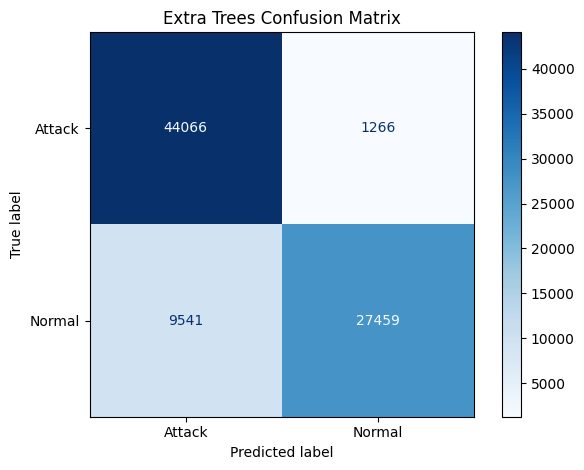

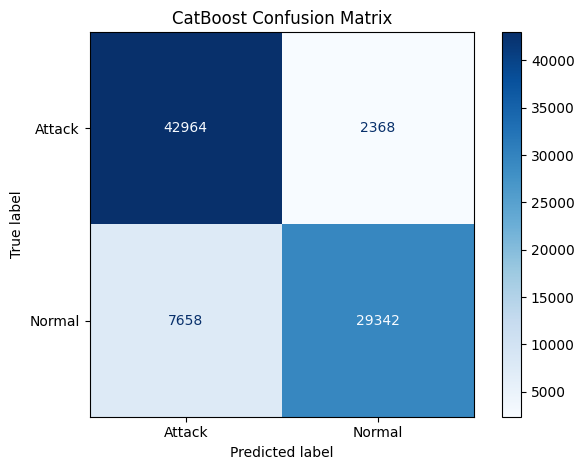

In [28]:
# =========================================================
# CELL 14: CONFUSION MATRIX VISUALIZATION
# Displays classification performance
# =========================================================

for model, name in [(et, "Extra Trees"), (cb, "CatBoost")]:
    cm = confusion_matrix(y_test, model.predict(X_test_enc))
    disp = ConfusionMatrixDisplay(cm, display_labels=target_le.classes_)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(name + " Confusion Matrix")
    plt.tight_layout()
    plt.show()


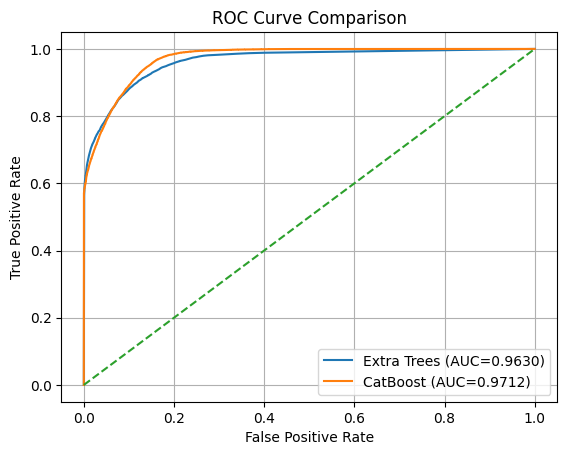

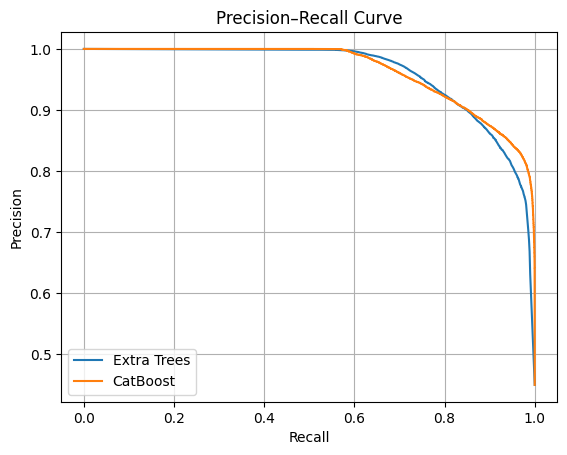

In [29]:
# =========================================================
# CELL 15: ROC AND PRECISION-RECALL CURVES
# Evaluates model discrimination ability
# =========================================================

et_prob = et.predict_proba(X_test_enc)[:, 1]
cb_prob = cb.predict_proba(X_test_enc)[:, 1]

plt.figure()
fpr_et, tpr_et, _ = roc_curve(y_test, et_prob)
fpr_cb, tpr_cb, _ = roc_curve(y_test, cb_prob)

plt.plot(fpr_et, tpr_et, label=f"Extra Trees (AUC={roc_auc_score(y_test, et_prob):.4f})")
plt.plot(fpr_cb, tpr_cb, label=f"CatBoost (AUC={roc_auc_score(y_test, cb_prob):.4f})")
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
for prob, name in [(et_prob, "Extra Trees"), (cb_prob, "CatBoost")]:
    p, r, _ = precision_recall_curve(y_test, prob)
    plt.plot(r, p, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()
